In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

"""
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [2]:
# Path to the Dataset
path = "/kaggle/input/facerecogprocesses/Gray_Faces/"

In [3]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
random.shuffle(dir_list)

In [4]:
all_faces_paths = []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()
    images = [path+directory+'/'+x for x in images]
    all_faces_paths.append(images) 

**Train, Validation, and Test Split**

We use faces of 1430 people for training, 200 faces for validation, and 50 faces for test

In [5]:
train_set, val_set, test_set = all_faces_paths[:1430], all_faces_paths[1430:1630], all_faces_paths[1630:1680]

In [6]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

1430
200
50


In [7]:
# All the images will be converted to the same size before processing
img_h, img_w = 160, 160

In [8]:
def visualize_sample_face():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k1 = np.random.randint(len(train_set))
    k2 = np.random.randint(len(train_set))
    same_img_names = random.sample(train_set[k1], 2)
    diff_img_name = random.sample(train_set[k2], 1)
    same_img1 = cv2.imread(same_img_names[0], 0)
    same_img2 = cv2.imread(same_img_names[1], 0)
    diff_img = plt.imread(diff_img_name[0], 0)

    ax1.imshow(same_img1, cmap = 'gray')
    ax2.imshow(same_img2, cmap = 'gray')
    ax3.imshow(diff_img, cmap = 'gray')

    ax1.set_title('Anchor')
    ax1.axis('off')
    ax2.set_title('Positive')
    ax2.axis('off')
    ax3.set_title('Negative')
    ax3.axis('off')

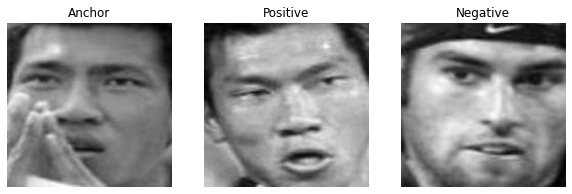

In [9]:
visualize_sample_face()

In [10]:
same_pairs = []
diff_pairs = []
for person in train_set:
    same_comb = list(itertools.combinations(person, 2))
    same_pairs.extend(same_comb)
    faces_minus_current = [j for j in train_set if j != person]
    for i in range(len(person)):
        if len(same_comb) == 1:
            diff_pairs.extend(itertools.product(person[i:i+1], random.sample(random.sample(faces_minus_current,1)[0], 1)))
        else:  
            for j in range(len(same_comb)//len(person)):
                diff_pairs.extend(itertools.product(person[i:i+1], random.sample(random.sample(faces_minus_current,1)[0], 1)))            

In [11]:
print("Number of similar pairs for train", len(same_pairs))
print("Number of different pairs train", len(diff_pairs))

Number of similar pairs for train 44362
Number of different pairs train 43622


In [12]:
same_pairs = []
diff_pairs = []
for person in val_set:
    same_comb = list(itertools.combinations(person, 2))
    same_pairs.extend(same_comb)
    faces_minus_current = [j for j in train_set if j != person]
    for i in range(len(person)):
        if len(same_comb) == 1:
            diff_pairs.extend(itertools.product(person[i:i+1], random.sample(random.sample(faces_minus_current,1)[0], 1)))
        else:  
            for j in range(len(same_comb)//len(person)):
                diff_pairs.extend(itertools.product(person[i:i+1], random.sample(random.sample(faces_minus_current,1)[0], 1)))            

In [13]:
print("Number of similar pairs for val", len(same_pairs))
print("Number of different pairs val", len(diff_pairs))

Number of similar pairs for val 6760
Number of different pairs val 6687


In [14]:
def generate_batch(persons, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        same_pairs = []
        diff_pairs = []
        same_same_labels = []
        same_diff_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 2 to 50 faces. For each person we create equal number of Same-Same and Same-Diff face pairs.
        # Where same-same means both images belong to the same person and same-diff means both images belong to different person. 
        # Minimum number of Same-Same pairs is 2 choose 2 = 1 and maximum number of Same-Same pair is 50 choose 2 = 1225
        # To make Same-Diff pairs, we pair every face image of a person with (Number of same-same pair / Number of images for the person)  
        # But when we have just one instance of Same-Same pair we create two instances of Same-Diff pair
        # In all we have 1400 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 46650
        # Total number of Genuine-Forged pairs = 45917
        # Total no. of data points = 46650 + 46650 = 92567
        

        for person in persons:
            same_comb = list(itertools.combinations(person, 2))
            same_pairs.extend(same_comb)
            faces_minus_current = [j for j in persons if j != person]
            for i in range(len(person)):
                if len(same_comb) == 1:
                    diff_pairs.extend(itertools.product(person[i:i+1], random.sample(random.sample(faces_minus_current,1)[0], 1)))
                else:  
                    for j in range(len(same_comb)//len(person)):
                        diff_pairs.extend(itertools.product(person[i:i+1], random.sample(random.sample(faces_minus_current,1)[0], 1))) 
        
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        same_same_labels = [1]*len(same_pairs)
        same_diff_labels = [0]*len(diff_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = same_pairs + diff_pairs
        all_labels = same_same_labels + same_diff_labels
        del same_pairs, diff_pairs, same_same_labels, same_diff_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))


In [15]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [16]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [17]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [18]:
def create_base_network(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(6, kernel_size=(5, 5), activation='relu', name='Conv1', strides=2, input_shape= input_shape, 
                        kernel_initializer='glorot_normal'))
    seq.add(MaxPooling2D((3,3), strides=(2, 2))) 
    seq.add(Dropout(.25))
    
    seq.add(Conv2D(12, kernel_size=(5, 5), activation='relu', name='Conv2', strides=2, kernel_initializer='glorot_normal'))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(.25))

    seq.add(Flatten(name='Flatten'))
    seq.add(Dense(128, activation='relu', kernel_initializer='glorot_normal')) 
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    
    return seq

In [19]:
input_shape=(img_h, img_w, 1)

In [20]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

2022-04-18 07:44:09.570080: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 07:44:09.656756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 07:44:09.657575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-18 07:44:09.658722: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [21]:
batch_sz = 128
num_train_samples = 46650 + 45917 
num_val_samples = 5648 + 5549 
num_train_samples, num_val_samples

(92567, 11197)

In [22]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [23]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./siam-face-recognition-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [24]:
results = model.fit_generator(generate_batch(train_set, batch_sz),
                              steps_per_epoch = num_train_samples//batch_sz,
                              epochs = 50,
                              validation_data = generate_batch(val_set, batch_sz),
                              validation_steps = num_val_samples//batch_sz,
                              callbacks = callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-18 07:44:14.740541: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-04-18 07:44:16.355292: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


723/723 [==============================] - 275s 372ms/step - loss: 0.2625 - val_loss: 0.4129

Epoch 00001: saving model to ./siam-face-recognition-001.h5
Epoch 2/50
723/723 [==============================] - 228s 316ms/step - loss: 0.2539 - val_loss: 0.4050

Epoch 00002: saving model to ./siam-face-recognition-002.h5
Epoch 3/50
723/723 [==============================] - 230s 318ms/step - loss: 0.2449 - val_loss: 0.3360

Epoch 00003: saving model to ./siam-face-recognition-003.h5
Epoch 4/50
723/723 [==============================] - 226s 313ms/step - loss: 0.2277 - val_loss: 0.2834

Epoch 00004: saving model to ./siam-face-recognition-004.h5
Epoch 5/50
723/723 [==============================] - 224s 310ms/step - loss: 0.2127 - val_loss: 0.2599

Epoch 00005: saving model to ./siam-face-recognition-005.h5
Epoch 6/50
723/723 [==============================] - 223s 308ms/step - loss: 0.2041 - val_loss: 0.2453

Epoch 00006: saving model to ./siam-face-recognition-006.h5
Epoch 7/50
723/723 [=

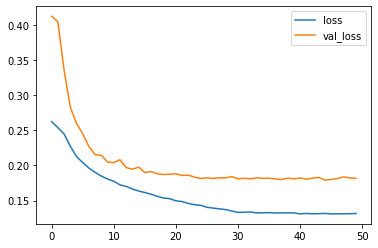

In [25]:
#%% Plot the Change in Loss over Epochs
for key in ['loss', 'val_loss']:
  plt.plot(results.history[key], label=key)

plt.legend()
plt.show()

### Load weights of the best model

In [26]:
NUM_TRIALS = 50 ## Trials for Testing Accuracy

# test with many randomly selected images
matching = 0
for tiral in range(NUM_TRIALS):
    filelist = test_set[np.random.randint(len(test_set))]
    index = np.random.randint(len(filelist))
    path_to_ref = filelist[index]
    cat_ref = path_to_ref.split("/")[-2]
    ref_img = cv2.imread(path_to_ref, 0)
    ref_img = cv2.resize(ref_img, (img_w, img_h))
    ref_img = np.array(ref_img, dtype = np.float64)
    ref_img /= 255
    ref_img = ref_img[..., np.newaxis]

    results = []
    for index in range(len(test_set)):
        filelist = test_set[index]
        idx = np.random.randint(len(filelist))
        path_to_cur = filelist[idx]
        cat_cur = path_to_cur.split("/")[-2]
        cur_img = cv2.imread(path_to_cur, 0)
        cur_img = cv2.resize(cur_img, (img_w, img_h))
        cur_img = np.array(cur_img, dtype = np.float64)
        cur_img /= 255
        cur_img = cur_img[..., np.newaxis]
        pairs=[np.zeros((1, img_h, img_w, 1)) for i in range(2)]
        pairs[0][0, :, :, :] = ref_img
        pairs[1][0, :, :, :] = cur_img
        dist = model.predict([pairs[0], pairs[1]])[0][0]
        results.append((cat_cur, dist))
    results.sort(key = lambda x : x[1])       

    if cat_ref ==  results[0][0]:
        matching += 1 

In [27]:
print("Accuracy: %5.2f %%\n" % (100.0 * matching / NUM_TRIALS))

Accuracy: 44.00 %



### Save the model for inference

In [28]:
model.save('siam-face-recognition.h5')